# PROJET 7 - Développez une preuve de concept

Nous nous plaçons ici dans le cadre d'un problème de classification de données textuelles : il s'agit ici de développer un système de suggestion de tags pour le site Stack Overflow c'est-à-dire assigner automatiquement plusieurs tags pertinents à une question. 

L'objectif de ce projet est de trouver une méthode plus récente pour améliorer la méthode déjà utilisée en production. 

Les données ont été récupérées à partir de l'outil d’export de données de Stack Overflow, https://data.stackexchange.com/stackoverflow/query/new et ont été traitées préalablement :
* suppression des balises HTML
* suppression de la ponctuation et des majuscules
* suppression des stopwords
* suppression des nombres seuls, des mots à 1 lettre et des espaces

# Importation des librairies

In [ ]:
# coding: utf-8

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import timeit
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Dense ##, Input
from tensorflow import keras

In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 89 kB 4.0 MB/s 


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

# Chargement des jeux de données

In [ ]:
data = pd.read_csv('QueryResults_clean.csv', sep = ",")
data.head(5)

,Body,Title,Tags
0,statement extract sections docx autonumbering ...,docx auto pythondocx,python
1,xarray dataset regression variables dimension ...,xarray operations dataset,python
2,number complexity optimizations check bigo pro...,prime bigo,c++
3,meaning statement section interpretations form...,meaning dot lmy,r
4,recognizer opencvcontrib line modules thing la...,attributeerror attribute createlbphfacerecognizer,"python, python-3.x"


In [ ]:
data.isnull().sum()

Body     0
Title    0
Tags     0
dtype: int64

# **Méthode baseline : OneVersusRest et SGDClassifier**

In [ ]:
data.head(3)

,Body,Title,Tags
0,statement extract sections docx autonumbering ...,docx auto pythondocx,python
1,xarray dataset regression variables dimension ...,xarray operations dataset,python
2,number complexity optimizations check bigo pro...,prime bigo,c++


In [ ]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44501 entries, 0 to 44500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    44501 non-null  object
 1   Title   44501 non-null  object
 2   Tags    44501 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


## Création des jeux de données - 'Body'

In [ ]:
## Vectorisation tf-idf des messages Body

tf_idf_vec = TfidfVectorizer() 
tf_idf_data = tf_idf_vec.fit_transform(data['Body'])
tf_idf_data

<44501x69685 sparse matrix of type '<class 'numpy.float64'>'
	with 664913 stored elements in Compressed Sparse Row format>

In [ ]:
tf_idf_data.shape

(44501, 69685)

In [ ]:
data['Tags_liste'] = data.apply(lambda row : row['Tags'].split(', '), axis=1)
target = pd.get_dummies(data['Tags_liste'].apply(pd.Series).stack()).sum(level=0)
target = target.iloc[:, 1:]
target.shape

(44501, 99)

In [ ]:
## Séparation en jeu de données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(tf_idf_data, target, test_size=0.3) # 30% des données dans le jeu de test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31150, 69685)
(13351, 69685)
(31150, 99)
(13351, 99)


## Analyse sur le jeu d'entraînement et sélection des hyperparamètres par validation croisée - 'Body'

In [ ]:
## Grille des hyperparamètres
param_grid = {'estimator__alpha' : [10, 1, 0.01, 0.001, 1e-04, 1e-05, 1e-06], 'estimator__penalty' : ['l1', 'l2']}

# Créer un classifieur avec recherche d'hyperparamètres par validation croisée
ovr_classifier = OneVsRestClassifier(SGDClassifier(n_jobs=-1))
score = 'accuracy'
model_grid = GridSearchCV(ovr_classifier, param_grid, cv=2, scoring = score) 

# Optimiser ce classifieur sur le jeu d'entraînement
model = model_grid.fit(X_train, y_train)

# Afficher les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_grid.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}


In [ ]:
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['std_test_score'], model.cv_results_['params']):
  print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, mean, std*2, params))

Résultats de la validation croisée :
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 10, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 10, 'estimator__penalty': 'l2'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 1, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 1, 'estimator__penalty': 'l2'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.079 (+/-0.001) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.036 (+/-0.001) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l2'}
accuracy = 0.188 (+/-0.008) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l1'}
accuracy = 0.177 (+/-0.009) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l2'}
accuracy = 0.215 (+/-0.005) for {'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}
accuracy 

## Evaluation du modèle - 'Body'

In [ ]:
## Evaluation du modèle sur le jeu d'entrainement

start_time = timeit.default_timer()
y_train_model = model.predict(X_train)
elapsed_train = timeit.default_timer() - start_time

accuracy_score_train = accuracy_score(y_train, y_train_model)

print('Sur le jeu d\'entrainement :')
print('Temps de calcul :', elapsed_train)
print('Accuracy :', accuracy_score_train)

Sur le jeu d'entrainement :
Temps de calcul : 0.16706777800004602
Accuracy : 0.5515890850722311


In [ ]:
## Evaluation du modèle sur le jeu de test 

start_time = timeit.default_timer()
y_test_model = model.predict(X_test)
elapsed_test = timeit.default_timer() - start_time

accuracy_score_test = accuracy_score(y_test, y_test_model)

print('Sur le jeu de test :')
print('Temps de calcul :', elapsed_test)
print('Accuracy :', accuracy_score_test)

Sur le jeu de test :
Temps de calcul : 0.09837793800011241
Accuracy : 0.2573589993258932


In [ ]:
results = pd.DataFrame(columns = ['Méthode', 'Accuracy', 'Temps_calcul'])
results.loc[0] = ['Méthode_baseline_Body', accuracy_score_test, elapsed_test]
results

,Méthode,Accuracy,Temps_calcul
0,Méthode_baseline_Body,0.257359,0.098378


## Création des jeux de données - 'Title'

In [ ]:
## Vectorisation tf-idf des messages Body

tf_idf_vec = TfidfVectorizer() 
tf_idf_data = tf_idf_vec.fit_transform(data['Title'])
tf_idf_data

<44501x18426 sparse matrix of type '<class 'numpy.float64'>'
	with 122796 stored elements in Compressed Sparse Row format>

In [ ]:
print(tf_idf_data.shape)
print(target.shape)

(44501, 18426)
(44501, 99)


In [ ]:
data['Tags_liste'] = data.apply(lambda row : row['Tags'].split(', '), axis=1)
target = pd.get_dummies(data['Tags_liste'].apply(pd.Series).stack()).sum(level=0)
target = target.iloc[:, 1:]
target.shape

(44501, 99)

In [ ]:
## Séparation en jeu de données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(tf_idf_data, target, test_size=0.3) # 30% des données dans le jeu de test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31150, 18426)
(13351, 18426)
(31150, 99)
(13351, 99)


## Analyse sur le jeu d'entraînement et sélection des hyperparamètres par validation croisée - 'Title'

In [ ]:
## Grille des hyperparamètres
param_grid = {'estimator__alpha' : [10, 1, 0.01, 0.001, 1e-04, 1e-05, 1e-06], 'estimator__penalty' : ['l1', 'l2']}

# Créer un classifieur avec recherche d'hyperparamètres par validation croisée
ovr_classifier = OneVsRestClassifier(SGDClassifier(n_jobs=-1))
score = 'accuracy'
model_grid = GridSearchCV(ovr_classifier, param_grid, cv=2, scoring = score) 

# Optimiser ce classifieur sur le jeu d'entraînement
model = model_grid.fit(X_train, y_train)

# Afficher les hyperparamètres optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_grid.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'estimator__alpha': 1e-05, 'estimator__penalty': 'l2'}


In [ ]:
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(model.cv_results_['mean_test_score'], model.cv_results_['std_test_score'], model.cv_results_['params']):
  print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, mean, std*2, params))

Résultats de la validation croisée :
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 10, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 10, 'estimator__penalty': 'l2'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 1, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 1, 'estimator__penalty': 'l2'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l1'}
accuracy = 0.001 (+/-0.000) for {'estimator__alpha': 0.01, 'estimator__penalty': 'l2'}
accuracy = 0.050 (+/-0.005) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l1'}
accuracy = 0.025 (+/-0.001) for {'estimator__alpha': 0.001, 'estimator__penalty': 'l2'}
accuracy = 0.151 (+/-0.002) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l1'}
accuracy = 0.148 (+/-0.001) for {'estimator__alpha': 0.0001, 'estimator__penalty': 'l2'}
accuracy = 0.170 (+/-0.003) for {'estimator__alpha': 1e-05, 'estimator__penalty': 'l1'}
accuracy 

## Evaluation du modèle - 'Title'

In [ ]:
## Evaluation du modèle sur le jeu d'entrainement

start_time = timeit.default_timer()
y_train_model = model.predict(X_train)
elapsed_train = timeit.default_timer() - start_time

accuracy_score_train = accuracy_score(y_train, y_train_model)

print('Sur le jeu d\'entrainement :')
print('Temps de calcul :', elapsed_train)
print('Accuracy :', accuracy_score_train)

Sur le jeu d'entrainement :
Temps de calcul : 0.08436919599989778
Accuracy : 0.5052006420545746


In [ ]:
## Evaluation du modèle sur le jeu de test 

start_time = timeit.default_timer()
y_test_model = model.predict(X_test)
elapsed_test = timeit.default_timer() - start_time

accuracy_score_test = accuracy_score(y_test, y_test_model)

print('Sur le jeu de test :')
print('Temps de calcul :', elapsed_test)
print('Accuracy :', accuracy_score_test)

Sur le jeu de test :
Temps de calcul : 0.046209191000116334
Accuracy : 0.20035952363118867


In [ ]:
results.loc[1] = ['Méthode_baseline_Title',  accuracy_score_test, elapsed_test]                  
results

,Méthode,Accuracy,Temps_calcul
0,Méthode_baseline_Body,0.257359,0.098378
1,Méthode_baseline_Title,0.200360,0.046209


# **Nouvelle méthode : Modèle Word Embedding et Deep Learning**

In [ ]:
data.head(5)

,Body,Title,Tags,Tags_liste
0,statement extract sections docx autonumbering ...,docx auto pythondocx,python,[python]
1,xarray dataset regression variables dimension ...,xarray operations dataset,python,[python]
2,number complexity optimizations check bigo pro...,prime bigo,c++,[c++]
3,meaning statement section interpretations form...,meaning dot lmy,r,[r]
4,recognizer opencvcontrib line modules thing la...,attributeerror attribute createlbphfacerecognizer,"python, python-3.x","[python, python-3.x]"


In [ ]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44501 entries, 0 to 44500
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Body        44501 non-null  object
 1   Title       44501 non-null  object
 2   Tags        44501 non-null  object
 3   Tags_liste  44501 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


## Préparation des données textuelles - 'Body'

In [ ]:
## Encodage des messages

def process_text(data):
  ## Tokeniser les messages
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
  tokenizer.fit_on_texts(data)

  ## Index numérique des mots contenus dans les messages
  word_index = tokenizer.word_index
  vocab_size = len(tokenizer.word_index) + 1

  ## Encoder les messages en séquences
  sequences = tokenizer.texts_to_sequences(data)

  ## Longueur maximale de la séquence
  maxlen = max([len(x) for x in sequences])

  ## Compresser les séquences à la même longuer
  padded = pad_sequences(sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

  return word_index, sequences, maxlen, padded, vocab_size

num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

messages = process_text(list(data['Body']))

In [ ]:
## Résultats du traitement des messages

print("Index des mots word_index :\n")
messages[0]

Index des mots word_index :



{'<UNK>': 1,
 'image': 2,
 'python': 3,
 'array': 4,
 'case': 5,
 'api': 6,
 'thanks': 7,
 'page': 8,
 'line': 9,
 'component': 10,
 'number': 11,
 'result': 12,
 'values': 13,
 'command': 14,
 'java': 15,
 'string': 16,
 'message': 17,
 'table': 18,
 'android': 19,
 'view': 20,
 'service': 21,
 'library': 22,
 'request': 23,
 'test': 24,
 'name': 25,
 'text': 26,
 'database': 27,
 'studio': 28,
 'script': 29,
 'answer': 30,
 'windows': 31,
 'idea': 32,
 'button': 33,
 'input': 34,
 'order': 35,
 'web': 36,
 'model': 37,
 'memory': 38,
 'default': 39,
 'google': 40,
 'core': 41,
 'column': 42,
 'docker': 43,
 'package': 44,
 'size': 45,
 'functions': 46,
 'folder': 47,
 'part': 48,
 'element': 49,
 'query': 50,
 'container': 51,
 'custom': 52,
 'html': 53,
 'console': 54,
 'module': 55,
 'exception': 56,
 'program': 57,
 'json': 58,
 'documentation': 59,
 'point': 60,
 'errors': 61,
 'instance': 62,
 'client': 63,
 'path': 64,
 'approach': 65,
 'system': 66,
 'eg': 67,
 'variable': 68,

In [ ]:
print("Séquences sequences :\n")
print(list(data['Body'])[0])
print(messages[1][0])

Séquences sequences :

statement extract sections docx autonumbering pythondocx text docx autonumbering
[191, 2759, 1115, 1, 1, 1, 26, 1, 1]


In [ ]:
print("Séquences des messages padded :\n")
messages[3]

Séquences des messages padded :



array([[ 191, 2759, 1115, ...,    0,    0,    0],
       [   1,  368, 1125, ...,    0,    0,    0],
       [  11,  593, 1324, ...,    0,    0,    0],
       ...,
       [1489,    8,   48, ...,    0,    0,    0],
       [ 646,  562,    1, ...,    0,    0,    0],
       [   6,  458,  522, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print('Longueur maxlen :', messages[2])
print('vocab_size :', messages[4])
print('Dimensions de padded :', messages[3].shape)
print('Type de sequences :', type(messages[1]))
print('Type de padded :', type(messages[3]))
maxlen = messages[2]
vocab_size = messages[4]
X = messages[3]

Longueur maxlen : 579
vocab_size : 69736
Dimensions de padded : (44501, 579)
Type de sequences : <class 'list'>
Type de padded : <class 'numpy.ndarray'>


In [ ]:
## Encodage des Tags

tags_list = data.apply(lambda row : row['Tags'].split(', '), axis=1)

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(list(tags_list))
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
noms_classes = list(mlb.classes_)
y.shape

(44501, 100)

In [ ]:
## Séparation en jeux de données d'entrainement et de test

test_size = 0.3
X_train, y_train, X_test, y_test = iterative_train_test_split(np.asmatrix(X), np.asmatrix(y), test_size = test_size)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31244, 579)
(13257, 579)
(31244, 100)
(13257, 100)


In [ ]:
## Vérification des jeux de données d'entrainement et de test

result = pd.DataFrame(index=['Train_attendu', 'Train_obtenu', 'Test_attendu', 'Test_obtenu'])

df = pd.DataFrame(np.asmatrix(y))
df_train = pd.DataFrame(y_train)
df_test = pd.DataFrame(y_test)

for i in range(df.shape[1]):
  Total_train = df_train[i].sum()
  Total_test = df_test[i].sum()
  Total = df[i].sum()
  result[i] = [Total*(1-test_size), Total_train, Total*test_size, Total_test]

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Train_attendu,362.6,324.1,502.6,374.5,2900.1,158.2,367.5,1812.3,264.6,531.3,184.1,541.8,151.9,217.7,234.5,564.2,1768.9,1801.8,290.5,196.7,827.4,396.9,227.5,348.6,739.2,187.6,226.1,182.0,151.2,541.8,711.9,479.5,177.8,259.0,249.9,150.5,228.9,925.4,154.0,1534.4,...,224.0,401.8,1010.8,259.0,402.5,225.4,658.7,325.5,931.0,156.8,190.4,172.2,4425.4,168.0,844.9,778.4,504.0,1366.4,207.9,196.7,205.8,534.8,546.7,338.1,241.5,217.0,1187.2,262.5,164.5,370.3,868.7,178.5,237.3,186.2,332.5,419.3,195.3,232.4,242.2,453.6
Train_obtenu,363.0,324.0,503.0,374.0,2900.0,158.0,368.0,1812.0,265.0,531.0,184.0,542.0,152.0,218.0,234.0,564.0,1769.0,1802.0,290.0,197.0,827.0,397.0,227.0,349.0,739.0,187.0,223.0,182.0,151.0,542.0,712.0,479.0,178.0,259.0,250.0,150.0,229.0,925.0,154.0,1534.0,...,224.0,402.0,1011.0,259.0,402.0,225.0,659.0,325.0,931.0,157.0,190.0,172.0,4425.0,168.0,845.0,778.0,504.0,1366.0,208.0,197.0,206.0,535.0,547.0,338.0,241.0,217.0,1187.0,262.0,164.0,370.0,869.0,176.0,237.0,186.0,332.0,419.0,195.0,232.0,242.0,454.0
Test_attendu,155.4,138.9,215.4,160.5,1242.9,67.8,157.5,776.7,113.4,227.7,78.9,232.2,65.1,93.3,100.5,241.8,758.1,772.2,124.5,84.3,354.6,170.1,97.5,149.4,316.8,80.4,96.9,78.0,64.8,232.2,305.1,205.5,76.2,111.0,107.1,64.5,98.1,396.6,66.0,657.6,...,96.0,172.2,433.2,111.0,172.5,96.6,282.3,139.5,399.0,67.2,81.6,73.8,1896.6,72.0,362.1,333.6,216.0,585.6,89.1,84.3,88.2,229.2,234.3,144.9,103.5,93.0,508.8,112.5,70.5,158.7,372.3,76.5,101.7,79.8,142.5,179.7,83.7,99.6,103.8,194.4
Test_obtenu,155.0,139.0,215.0,161.0,1243.0,68.0,157.0,777.0,113.0,228.0,79.0,232.0,65.0,93.0,101.0,242.0,758.0,772.0,125.0,84.0,355.0,170.0,98.0,149.0,317.0,81.0,100.0,78.0,65.0,232.0,305.0,206.0,76.0,111.0,107.0,65.0,98.0,397.0,66.0,658.0,...,96.0,172.0,433.0,111.0,173.0,97.0,282.0,140.0,399.0,67.0,82.0,74.0,1897.0,72.0,362.0,334.0,216.0,586.0,89.0,84.0,88.0,229.0,234.0,145.0,104.0,93.0,509.0,113.0,71.0,159.0,372.0,79.0,102.0,80.0,143.0,180.0,84.0,100.0,104.0,194.0


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Analyse sur le jeu d'entrainement et sélection des hyperparamètres optimaux par validation croisée - 'Body'

In [ ]:
## Définition du modèle

def create_model(num_filters, kernel_size, rate, units, lr, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate)) 
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(100, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
## Hyperparamètres du modèle

param_grid = dict(num_filters=[128],
                  kernel_size=[5],
                  units=[32, 64],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50, 100],
                  maxlen=[maxlen],
                  epochs = [30], 
                  batch_size = [20], 
                  lr = [0.001], 
                  rate = [0.0, 0.5])

In [ ]:
## Recherche des hyperparamètres optimaux

model = KerasClassifier(build_fn=create_model, verbose=1)
grid_param = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1)
stop_early = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
grid_result = grid_param.fit(X_train, y_train, callbacks=[stop_early])

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
782/782 [==============================] - 39s 11ms/step - loss: 0.1023 - accuracy: 0.1146
Epoch 2/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0606 - accuracy: 0.3389
Epoch 3/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0475 - accuracy: 0.4344
Epoch 4/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0409 - accuracy: 0.4896
Epoch 5/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0365 - accuracy: 0.5250
Epoch 6/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0330 - accuracy: 0.5528
Epoch 7/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0299 - accuracy: 0.5807
Epoch 8/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0272 - accuracy: 0.5999
Epoch 9/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0247 - accuracy: 0.6186
Epoch 10/30
782/782 [==============================] - 8s 11ms/step - loss: 0.0224 - accur

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 94.9min finished


Epoch 1/30
1563/1563 [==============================] - 26s 16ms/step - loss: 0.0856 - accuracy: 0.1861
Epoch 2/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0559 - accuracy: 0.3531
Epoch 3/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0493 - accuracy: 0.4150
Epoch 4/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0453 - accuracy: 0.4485
Epoch 5/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0426 - accuracy: 0.4732
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0405 - accuracy: 0.4875
Epoch 7/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0387 - accuracy: 0.5022
Epoch 8/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0373 - accuracy: 0.5138
Epoch 9/30
1563/1563 [==============================] - 25s 16ms/step - loss: 0.0359 - accuracy: 0.5252
Epoch 10/30
1563/1563 [==============================] - 25s 16m

In [ ]:
# Afficher les hyperparamètres optimaux

print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_params = grid_result.best_params_

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
Best: 0.423465 using {'batch_size': 20, 'embedding_dim': 100, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.5, 'units': 32, 'vocab_size': 69736}


In [ ]:
# Afficher les performances correspondantes

print("Résultats de la validation croisée :")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Résultats de la validation croisée :
0.381893 (0.002989) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.0, 'units': 32, 'vocab_size': 69736}
0.384389 (0.000172) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.0, 'units': 64, 'vocab_size': 69736}
0.412648 (0.006478) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.5, 'units': 32, 'vocab_size': 69736}
0.414056 (0.012046) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.5, 'units': 64, 'vocab_size': 69736}
0.398150 (0.003796) with: {'batch_size': 20, 'embedding_dim': 100, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 579, 'num_filters': 128, 'rate': 0.0, 'units': 32, 'vocab_size': 6973

## Evaluation du modèle - 'Body'

In [ ]:
## Modèle avec les paramètres optimaux

model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     rate=best_params['rate'],
                     units=best_params['units'],
                     lr=best_params['lr'],
                     vocab_size=best_params['vocab_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 579, 100)          6973600   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 575, 128)          64128     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 128)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_35 (Dense)             (None, 100)             

In [ ]:
## Evaluation du modèle sur le jeu de données d'entrainement

start_time = timeit.default_timer()
accuracy_train = grid_param.score(X_train, y_train)
elapsed_train = timeit.default_timer() - start_time

1563/1563 [==============================] - 8s 5ms/step - loss: 0.0169 - accuracy: 0.6607


In [ ]:
## Evaluation du modèle sur le jeu de données test

start_time = timeit.default_timer()
accuracy_test = grid_param.score(X_test, y_test)
elapsed_test = timeit.default_timer() - start_time

663/663 [==============================] - 3s 5ms/step - loss: 0.0530 - accuracy: 0.4453


In [ ]:
results.loc[2] = ['CNN_Embedding_Body', accuracy_test, elapsed_test]
results

,Méthode,Accuracy,Temps_calcul
0,Méthode_baseline_Body,0.257359,0.098378
1,Méthode_baseline_Title,0.200360,0.046209
2,CNN_Embedding_Body,0.445300,3.517632


## Préparation des données textuelles - 'Title'

In [ ]:
## Encodage des messages

num_words = 5000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

messages = process_text(list(data['Title']))

In [ ]:
## Résultats du traitement des messages

print("Index des mots word_index :\n")
messages[0]

Index des mots word_index :



{'<UNK>': 1,
 'typescript': 2,
 'element': 3,
 'xcode': 4,
 'property': 5,
 'boot': 6,
 'view': 7,
 'service': 8,
 'user': 9,
 'command': 10,
 'css': 11,
 'aws': 12,
 'page': 13,
 'functions': 14,
 'objects': 15,
 'button': 16,
 'kotlin': 17,
 'django': 18,
 'input': 19,
 'container': 20,
 'line': 21,
 'library': 22,
 'default': 23,
 'template': 24,
 'memory': 25,
 'swiftui': 26,
 'size': 27,
 'database': 28,
 'elements': 29,
 'web': 30,
 'columns': 31,
 'query': 32,
 'sql': 33,
 'variables': 34,
 'chrome': 35,
 'loop': 36,
 'nodejs': 37,
 'html': 38,
 'package': 39,
 'issue': 40,
 'script': 41,
 'php': 42,
 'js': 43,
 'path': 44,
 'navigation': 45,
 'date': 46,
 'background': 47,
 'stream': 48,
 'model': 49,
 'framework': 50,
 'color': 51,
 'parameter': 52,
 'test': 53,
 'key': 54,
 'url': 55,
 'form': 56,
 'map': 57,
 'connection': 58,
 'cloud': 59,
 'exception': 60,
 'directory': 61,
 'reference': 62,
 'npm': 63,
 'row': 64,
 'bar': 65,
 'order': 66,
 'response': 67,
 'keras': 68,
 

In [ ]:
print("Séquences sequences :\n")
messages[1][0]

Séquences sequences :



[2065, 292, 3787]

In [ ]:
print("Séquences des messages padded :\n")
messages[3]

Séquences des messages padded :



array([[2065,  292, 3787, ...,    0,    0,    0],
       [2798,  575,  707, ...,    0,    0,    0],
       [3788, 2799,    0, ...,    0,    0,    0],
       ...,
       [1489, 1487, 2787, ...,    0,    0,    0],
       [ 362, 4676,    1, ...,    0,    0,    0],
       [  67,  177,    0, ...,    0,    0,    0]], dtype=int32)

In [ ]:
print('Longueur maxlen :', messages[2])
print('vocab_size :', messages[4])
print('Dimensions de padded :', messages[3].shape)
print('Type de sequences :', type(messages[1]))
print('Type de padded :', type(messages[3]))
maxlen = messages[2]
vocab_size = messages[4]
X = messages[3]

Longueur maxlen : 12
vocab_size : 18429
Dimensions de padded : (44501, 12)
Type de sequences : <class 'list'>
Type de padded : <class 'numpy.ndarray'>


In [ ]:
noms_classes = list(mlb.classes_)
y.shape

(44501, 100)

In [ ]:
## Séparation en jeux de données d'entrainement et de test

test_size = 0.3
X_train, y_train, X_test, y_test = iterative_train_test_split(np.asmatrix(X), np.asmatrix(y), test_size = test_size)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31249, 12)
(13252, 12)
(31249, 100)
(13252, 100)


In [ ]:
## Vérification des jeux de données d'entrainement et de test

result = pd.DataFrame(index=['Train_attendu', 'Train_obtenu', 'Test_attendu', 'Test_obtenu'])

df = pd.DataFrame(np.asmatrix(y))
df_train = pd.DataFrame(y_train)
df_test = pd.DataFrame(y_test)

for i in range(df.shape[1]):
  Total_train = df_train[i].sum()
  Total_test = df_test[i].sum()
  Total = df[i].sum()
  result[i] = [Total*(1-test_size), Total_train, Total*test_size, Total_test]

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Train_attendu,362.6,324.1,502.6,374.5,2900.1,158.2,367.5,1812.3,264.6,531.3,184.1,541.8,151.9,217.7,234.5,564.2,1768.9,1801.8,290.5,196.7,827.4,396.9,227.5,348.6,739.2,187.6,226.1,182.0,151.2,541.8,711.9,479.5,177.8,259.0,249.9,150.5,228.9,925.4,154.0,1534.4,...,224.0,401.8,1010.8,259.0,402.5,225.4,658.7,325.5,931.0,156.8,190.4,172.2,4425.4,168.0,844.9,778.4,504.0,1366.4,207.9,196.7,205.8,534.8,546.7,338.1,241.5,217.0,1187.2,262.5,164.5,370.3,868.7,178.5,237.3,186.2,332.5,419.3,195.3,232.4,242.2,453.6
Train_obtenu,363.0,324.0,503.0,375.0,2900.0,158.0,367.0,1812.0,265.0,531.0,184.0,542.0,152.0,218.0,234.0,564.0,1769.0,1802.0,290.0,197.0,827.0,397.0,227.0,349.0,739.0,188.0,224.0,182.0,151.0,542.0,712.0,479.0,178.0,259.0,250.0,151.0,229.0,925.0,154.0,1534.0,...,224.0,402.0,1011.0,259.0,402.0,225.0,659.0,325.0,931.0,156.0,190.0,172.0,4425.0,168.0,845.0,778.0,504.0,1366.0,208.0,197.0,206.0,535.0,547.0,338.0,241.0,217.0,1187.0,262.0,165.0,370.0,869.0,174.0,237.0,186.0,332.0,419.0,195.0,232.0,242.0,454.0
Test_attendu,155.4,138.9,215.4,160.5,1242.9,67.8,157.5,776.7,113.4,227.7,78.9,232.2,65.1,93.3,100.5,241.8,758.1,772.2,124.5,84.3,354.6,170.1,97.5,149.4,316.8,80.4,96.9,78.0,64.8,232.2,305.1,205.5,76.2,111.0,107.1,64.5,98.1,396.6,66.0,657.6,...,96.0,172.2,433.2,111.0,172.5,96.6,282.3,139.5,399.0,67.2,81.6,73.8,1896.6,72.0,362.1,333.6,216.0,585.6,89.1,84.3,88.2,229.2,234.3,144.9,103.5,93.0,508.8,112.5,70.5,158.7,372.3,76.5,101.7,79.8,142.5,179.7,83.7,99.6,103.8,194.4
Test_obtenu,155.0,139.0,215.0,160.0,1243.0,68.0,158.0,777.0,113.0,228.0,79.0,232.0,65.0,93.0,101.0,242.0,758.0,772.0,125.0,84.0,355.0,170.0,98.0,149.0,317.0,80.0,99.0,78.0,65.0,232.0,305.0,206.0,76.0,111.0,107.0,64.0,98.0,397.0,66.0,658.0,...,96.0,172.0,433.0,111.0,173.0,97.0,282.0,140.0,399.0,68.0,82.0,74.0,1897.0,72.0,362.0,334.0,216.0,586.0,89.0,84.0,88.0,229.0,234.0,145.0,104.0,93.0,509.0,113.0,70.0,159.0,372.0,81.0,102.0,80.0,143.0,180.0,84.0,100.0,104.0,194.0


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## Analyse sur le jeu d'entrainement et sélection des hyperparamètres optimaux par validation croisée - 'Title'

In [ ]:
## Définition du modèle

def create_model(num_filters, kernel_size, rate, units, lr, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate)) 
    model.add(Flatten())
    model.add(Dense(units, activation='relu'))
    model.add(Dense(100, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
## Hyperparamètres du modèle

param_grid = dict(num_filters=[128],
                  kernel_size=[5],
                  units=[32, 64],
                  vocab_size=[vocab_size], 
                  embedding_dim=[50, 100],
                  maxlen=[maxlen],
                  epochs = [30], 
                  batch_size = [20], 
                  lr = [0.001], 
                  rate = [0.0, 0.5])


In [ ]:
## Recherche des hyperparamètres optimaux

model = KerasClassifier(build_fn=create_model, verbose=1)
grid_param = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1) 
stop_early = EarlyStopping(monitor='accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
grid_result = grid_param.fit(X_train, y_train, callbacks=[stop_early])

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


782/782 [==============================] - 5s 6ms/step - loss: 0.1099 - accuracy: 0.0755
Epoch 2/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0707 - accuracy: 0.1955
Epoch 3/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0602 - accuracy: 0.3005
Epoch 4/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0534 - accuracy: 0.3808
Epoch 5/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0488 - accuracy: 0.4158
Epoch 6/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0455 - accuracy: 0.4496
Epoch 7/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0430 - accuracy: 0.4638
Epoch 8/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0409 - accuracy: 0.4750
Epoch 9/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0391 - accuracy: 0.4872
Epoch 10/30
782/782 [==============================] - 4s 6ms/step - loss: 0.0375 - accuracy: 0.4970
Epoch 11/3

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 43.8min finished


1563/1563 [==============================] - 10s 6ms/step - loss: 0.0919 - accuracy: 0.0928
Epoch 2/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0659 - accuracy: 0.2459
Epoch 3/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0578 - accuracy: 0.3282
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0540 - accuracy: 0.3643
Epoch 5/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0517 - accuracy: 0.3823
Epoch 6/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0498 - accuracy: 0.3932
Epoch 7/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0481 - accuracy: 0.4051
Epoch 8/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0469 - accuracy: 0.4147
Epoch 9/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0456 - accuracy: 0.4239
Epoch 10/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0446 - accura

In [ ]:
# Afficher les hyperparamètres optimaux

print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_params = grid_result.best_params_

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
Best: 0.334795 using {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.5, 'units': 32, 'vocab_size': 18429}


In [ ]:
# Afficher les performances correspondantes

print("Résultats de la validation croisée :")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Résultats de la validation croisée :
0.306922 (0.006058) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.0, 'units': 32, 'vocab_size': 18429}
0.294506 (0.009194) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.0, 'units': 64, 'vocab_size': 18429}
0.334795 (0.004491) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.5, 'units': 32, 'vocab_size': 18429}
0.330891 (0.005259) with: {'batch_size': 20, 'embedding_dim': 50, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.5, 'units': 64, 'vocab_size': 18429}
0.296330 (0.003530) with: {'batch_size': 20, 'embedding_dim': 100, 'epochs': 30, 'kernel_size': 5, 'lr': 0.001, 'maxlen': 12, 'num_filters': 128, 'rate': 0.0, 'units': 32, 'vocab_size': 18429}
0.

## Evaluation du modèle - 'Title'

In [ ]:
## Modèle avec les paramètres optimaux

model = create_model(num_filters=best_params['num_filters'],
                     kernel_size=best_params['kernel_size'],
                     rate=best_params['rate'],
                     units=best_params['units'],
                     lr=best_params['lr'],
                     vocab_size=best_params['vocab_size'],
                     embedding_dim=best_params['embedding_dim'],
                     maxlen=best_params['maxlen'])

model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 12, 50)            921450    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 8, 128)            32128     
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 128)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_71 (Dense)             (None, 100)             

In [ ]:
## Evaluation du modèle sur le jeu de données d'entrainement

start_time = timeit.default_timer()
accuracy_train = grid_param.score(X_train, y_train)
elapsed_train = timeit.default_timer() - start_time

1563/1563 [==============================] - 4s 3ms/step - loss: 0.0299 - accuracy: 0.5310


In [ ]:
## Evaluation du modèle sur le jeu de données test

start_time = timeit.default_timer()
accuracy_test = grid_param.score(X_test, y_test)
elapsed_test = timeit.default_timer() - start_time

663/663 [==============================] - 2s 3ms/step - loss: 0.0653 - accuracy: 0.3568


In [ ]:
results.loc[3] = ['CNN_Embedding_Title', accuracy_test, elapsed_test]
results

,Méthode,Accuracy,Temps_calcul
0,Méthode_baseline_Body,0.257359,0.098378
1,Méthode_baseline_Title,0.200360,0.046209
2,CNN_Embedding_Body,0.445300,3.517632
3,CNN_Embedding_Title,0.356776,1.838852


# Comparaison des méthodes

In [ ]:
results

,Méthode,Accuracy,Temps_calcul
0,Méthode_baseline_Body,0.257359,0.098378
1,Méthode_baseline_Title,0.200360,0.046209
2,CNN_Embedding_Body,0.445300,3.517632
3,CNN_Embedding_Title,0.356776,1.838852


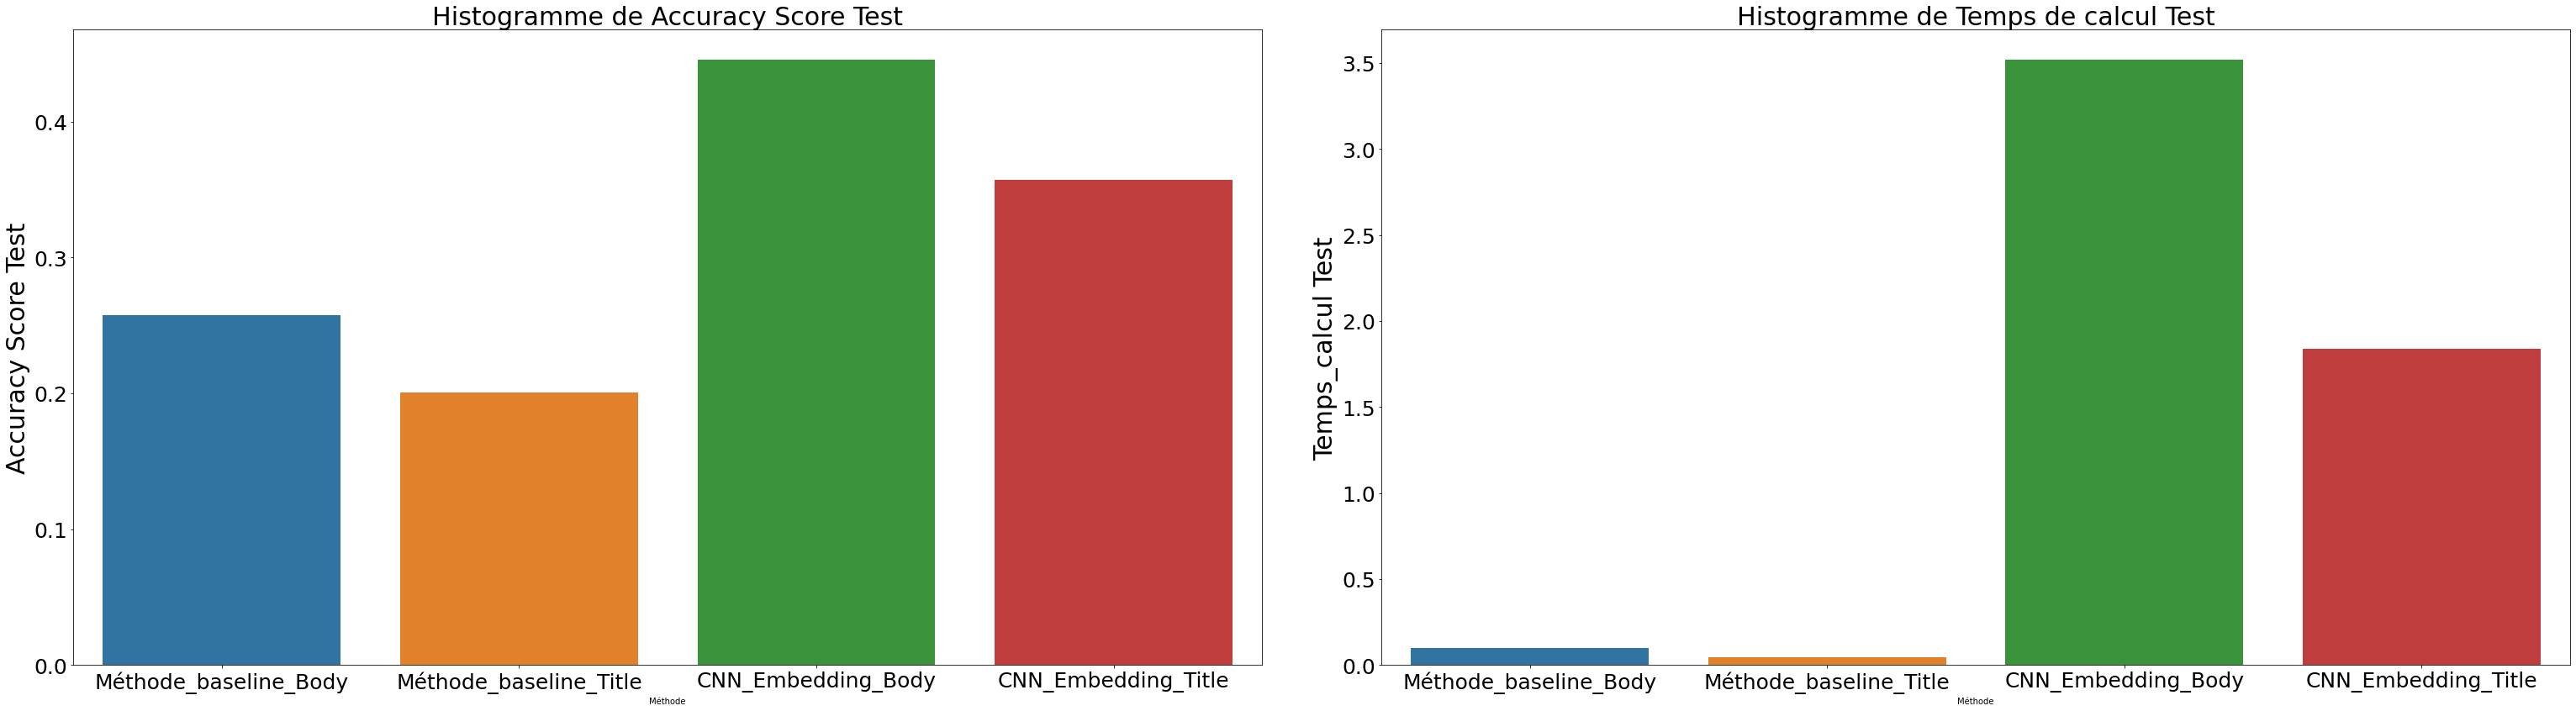

In [ ]:
plt.figure(1,figsize=(30,15))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.1, hspace = 0.2)

plt.subplot(1,2,1)
sns.barplot(x=results['Méthode'],y=results['Accuracy'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Accuracy Score Test", fontsize = 30)
plt.title('Histogramme de Accuracy Score Test', fontsize = 30)

plt.subplot(1,2,2)
sns.barplot(x=results['Méthode'],y=results['Temps_calcul'])
plt.tick_params(axis = 'both', labelsize = 25)
plt.ylabel("Temps_calcul Test", fontsize = 30)
plt.title('Histogramme de Temps de calcul Test', fontsize = 30)

plt.show()